# AKI Tensor-cell2cell

In [1]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/"

In [23]:
output_dir = "/home/dbdimitrov/Repos/liana2_manuscript/figures/"

In [2]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

### Setup Env

In [5]:
import numpy as np
import pandas as pd

import scanpy as sc

In [6]:
import decoupler as dc

In [7]:
import cell2cell as c2c
from collections import defaultdict

In [8]:
import plotnine as p9
import liana as li
li.__version__

'0.1.8'

In [9]:
adata = sc.read_h5ad(data_dir + "aki_processed.h5ad")

## Build Tensor

In [10]:
score_key = 'lr_probs'

In [37]:
tensor = li.multi.to_tensor_c2c(adata,
                                uns_key='liana_res',
                                sample_key=sample_key,
                                score_key=score_key, # can be any score from liana
                                how='outer', # how to join the samples
                                non_expressed_fill=0,
                                )

100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


In [38]:
c2c.io.export_variable_with_pickle(tensor, "tensor_aki.pkl")

tensor_aki.pkl  was correctly saved.


In [39]:
tensor.shape

(24, 1263, 18, 18)

In [40]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

## Run Tensor

In [41]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=10, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )



Running Tensor Factorization


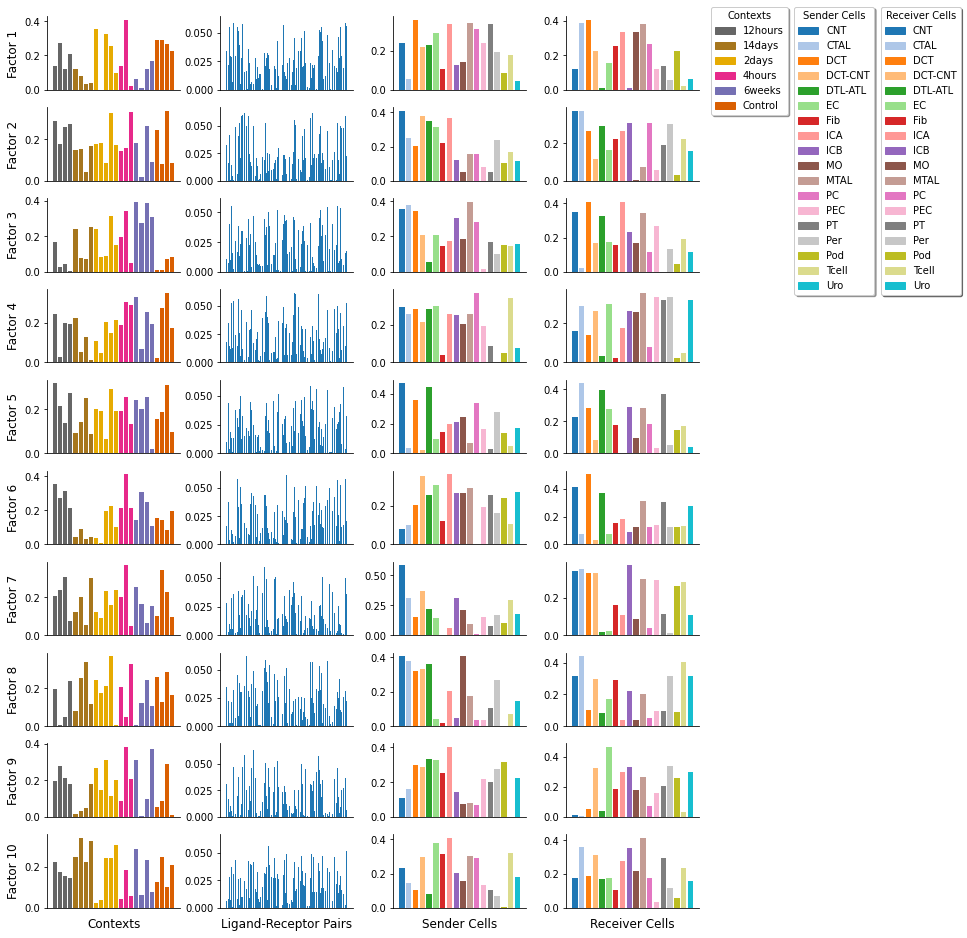

In [42]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['Dark2_r', None, 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [46]:
factors = tensor.factors

In [47]:
adata.obs[condition_key].unique()

['4hours', '12hours', '2days', '14days', '6weeks', 'Control']
Categories (6, object): ['2days', '4hours', '6weeks', '12hours', '14days', 'Control']

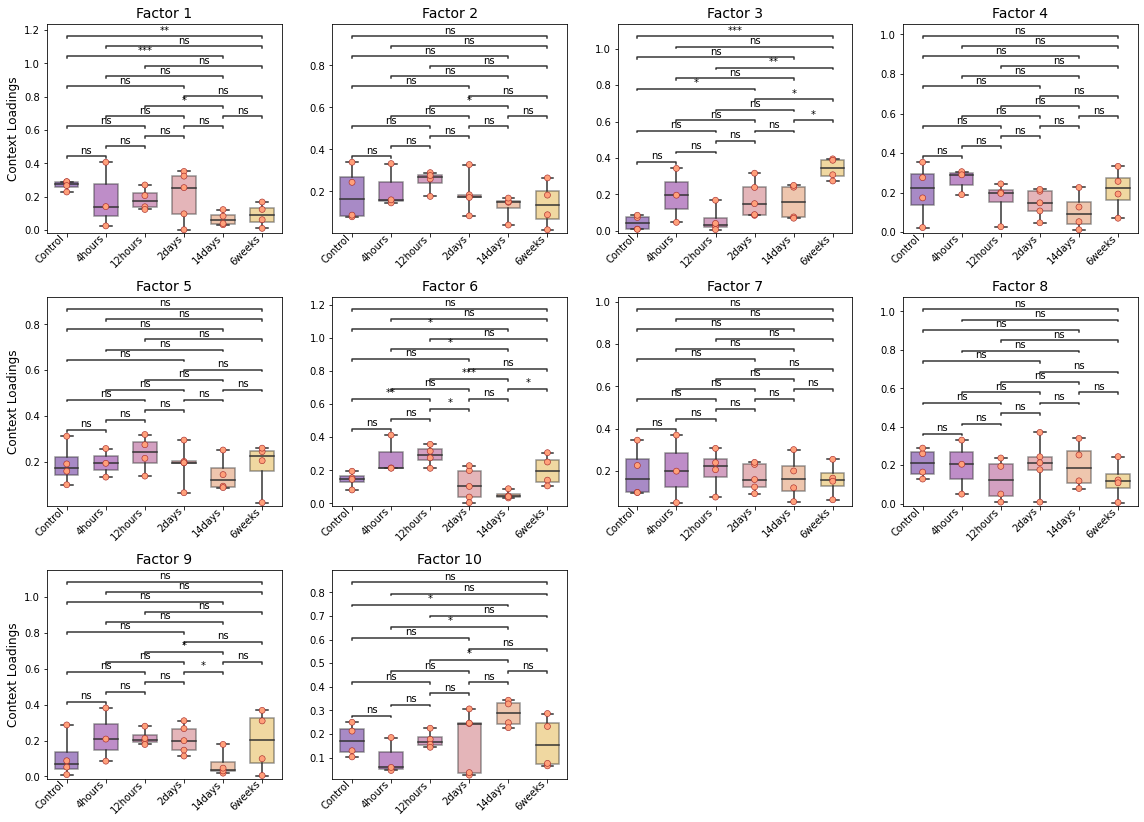

In [48]:
groups_order = ['Control', '4hours', '12hours', '2days', '14days', '6weeks']
fig_filename = output_dir + '/BALF-Severity-Boxplots.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=3,
                                 figsize=(16, 12),
                                 group_order=groups_order,
                                 statistical_test='t-test_ind',
                                 pval_correction=None,
                                 cmap='plasma',
                                 verbose=False,
                                 filename=fig_filename
                                )


In [51]:
import matplotlib.pyplot as plt

In [49]:
# Generate color by COVID-19 severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(groups_order, cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

# Generate a dataframe used as input for the clustermap
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['AKI']



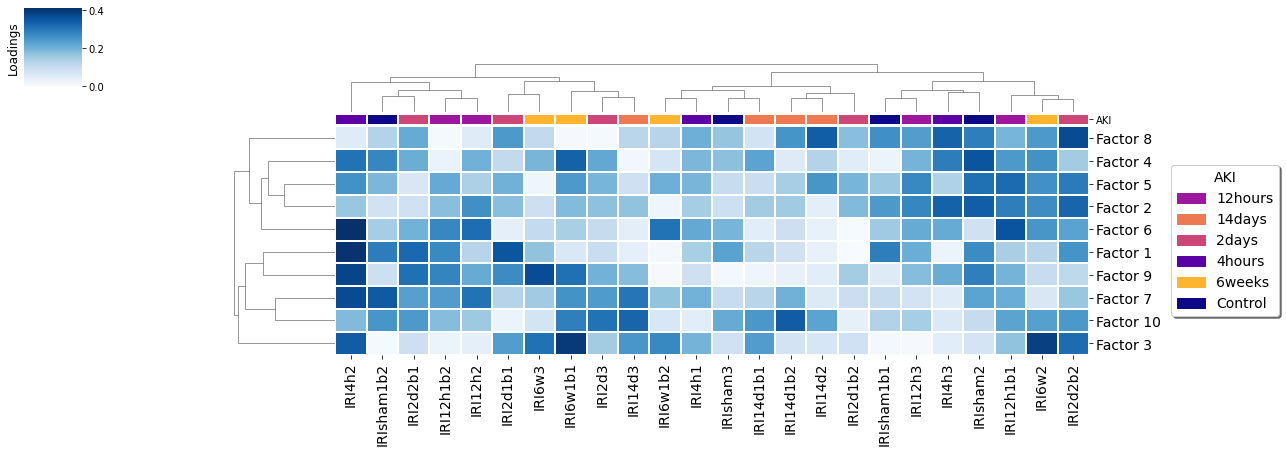

In [52]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=False, # Whether standardizing the loadings across factors
                                            col_colors=col_colors, # Change this to color by other properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            filename=output_dir + 'Clustermap-Contexts.pdf'
                                           )

#Insert legend
plt.sca(sample_cm.ax_heatmap)
legend = c2c.plotting.aesthetics.generate_legend(color_dict=condition_colors,
                                                 bbox_to_anchor=(1.1, 0.5), # Position of the legend (X, Y)
                                                 title='AKI'
                                                )

